# AIRDOS G data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob

In [2]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [9]:
fto = './data/malaga/16/DATALOG.TXT' #  File to Open
#fto = './data/malaga/21/DATALOG.TXT' #  File to Open
#fto = './data/malaga/98/DATALOG.TXT' #  File to Open
#fto = './data/malaga/F0/DATALOG.TXT' #  File to Open

print (fto)

l=[]
#l.extend(range(0,261))
l.extend(range(0,258))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS'][3]
print (sn[0])
#df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)

# Convert strings to numbers
#df = df.apply(pd.to_numeric, errors='ignore')

#df.iloc[:,0:13]

#df

./data/malaga/16/DATALOG.TXT
1290c00806a20091702fa000a0000016


## Derive measurement runs in to separate files

In [11]:
run = 0

runs = []
LatDD = np.nan
LatD = np.nan
LatM = np.nan
LonDD = np.nan
LonD = np.nan
LonM = np.nan

for i,r in df.iterrows():
    if (r[0] == '$AIRDOS'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        flag = 0
        flagrun = 0
        print (run, end='')
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        LatHem = r.astype(str)[4]
        LonHem = r.astype(str)[6]
        if (LatHem=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (LonHem=='W'):
            LonS = -1
        else:
            LonS = 1
        Lat = float(r[3])
        LatD = np.trunc(Lat/100)
        LatM = ((Lat/100) - LatD) * 100
        LatDD = LatD + LatM/60.0
        LatDD = LatDD * LatS  
        Lon = float(r[5])
        LonD = np.trunc(Lon/100)
        LonM = ((Lon/100) - LonD) * 100
        LonDD = LonD + LonM/60.0
        LonDD = LonDD * LonS         
        flag = 1
       
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$CANDY'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        date_line = date + pd.to_timedelta(time - timedelta, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        df.at[i,'latD'] = LatD
        df.at[i,'lonD'] = LonD
        df.at[i,'latM'] = LatM
        df.at[i,'lonM'] = LonM
        df.at[i,'latHem'] = LatHem
        df.at[i,'lonHem'] = LonHem
        
  
FROM = pd.to_datetime('2019-11-27 00:00:00')
TO = pd.to_datetime('2019-11-29 01:10:00')
#FROM = pd.to_datetime('2019-11-28 18:55:00')
#TO = pd.to_datetime('2019-11-29 01:00:00')
#PRG-AGP
#FROM = pd.to_datetime('2019-11-28 18:55:00')
#TO = pd.to_datetime('2019-11-28 20:55:00')
#AGP-PRG
#FROM = pd.to_datetime('2019-11-28 23:00:00')
#TO = pd.to_datetime('2019-11-29 00:30:00')


dfo = df.copy()
dfo = dfo.loc[(dfo['date']>FROM)&(dfo['date']<TO)]

#01/2002, FL-27
#DEG MIN N/S DEG MIN E/W FEET TIME(MIN)
dfdeg = df[['latD','latM','latHem','lonD','lonM','lonHem','altitude','run','date']].copy()
dfdeg['altitude'] *= 3.28084
dfdeg['minute'] = 0
dfo['minute'] = 0
dfdeg = dfdeg.loc[(dfdeg['date']>FROM)&(dfdeg['date']<TO)]
#dfdeg.reset_index(inplace=True)

dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)

'''
TODO !!!!!!!!!!!!!!!!!!!!
# calculate empty dates
for x in runs:
    print x
    dfo.loc[(dfo['date'].isnull())&(dfo['run'] == x[0]),'TBD'] = x[0]
    dfo.loc[dfo['TBD'] == x[0],'time'] = pd.to_datetime(x[1] + (pd.to_timedelta(pd.to_numeric(dfo.loc[dfo['TBD'] == x[0],2]), unit='s')) - pd.to_timedelta(x[2], unit='s'))
    dfo.loc[(dfo['time'].isnull())&(dfo['run'] == x[0]),'time'] = dfo.loc[(dfo['time'].isnull())&(dfo['run'] == x[0]),'date']

dfo.drop(['TBD','date'], axis = 1, inplace = True, errors = 'ignore')
'''
print ()

for f in glob.iglob("./output/*.csv"): # delete all output files 
    print ('Deleting', f)
    #os.remove(f)


dfo.set_index('date', inplace = True)

#01/2002, FL-27
#DEG MIN N/S DEG MIN E/W FEET TIME(MIN)

for x in runs: 
    filename = './output/' + str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0])

    # Disimetric values
    dfo.loc[dfo['run'] == x[0],'minute'] = (pd.to_timedelta(dfo.loc[dfo['run'] == x[0]].index-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)
    dfo.loc[dfo['run'] == x[0]].to_csv(filename + '.csv')

    # zeroing minutes for CARI
    zerominutes = np.round((pd.to_timedelta(dfdeg.iloc[0,8]-(x[1] + pd.to_timedelta(-x[2], unit='s')))).total_seconds()/60,0)

    # Telemetry for CARI 7
    with open(filename + '.DEG', 'w') as f:
        f.write('01/2002, FL-27\r\n')
        f.write('DEG MIN N/S DEG MIN E/W FEET TIME(MIN)\r\n')
    with open('ble.DEG', 'w') as f:
        f.write('11/2019, FL-27\r\n')
        f.write('DEG MIN N/S DEG MIN E/W FEET TIME(MIN)\r\n')
    #dfdeg.loc[dfdeg['run'] == x[0],'minute'] = (pd.to_timedelta(-dfdeg.iloc[0,8]+dfdeg['date']-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)-119
    #dfdeg.loc[dfdeg['run'] == x[0],'minute'] = (pd.to_timedelta(dfdeg['date']-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)-zerominutes
    dfdeg.loc[dfdeg['run'] == x[0],['latD','latM', 'latHem', 'lonD', 'lonM', 'lonHem', 'altitude', 'minute']].dropna().drop_duplicates(subset='minute', keep='first').to_csv('ble.DEG', mode='a', index=False, header=False, line_terminator='\r\n')

print('End')

1
Deleting ./output/2019-11-28 16:55:13_1290c00806a200912821a000a0000098.csv
End


In [715]:
np.round((pd.to_timedelta(dfdeg.iloc[0,8]-(x[1] + pd.to_timedelta(-x[2], unit='s')))).total_seconds()/60,0)


120.0

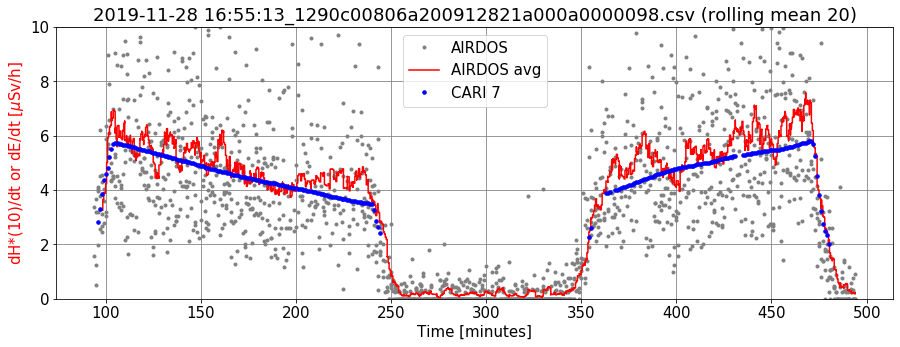

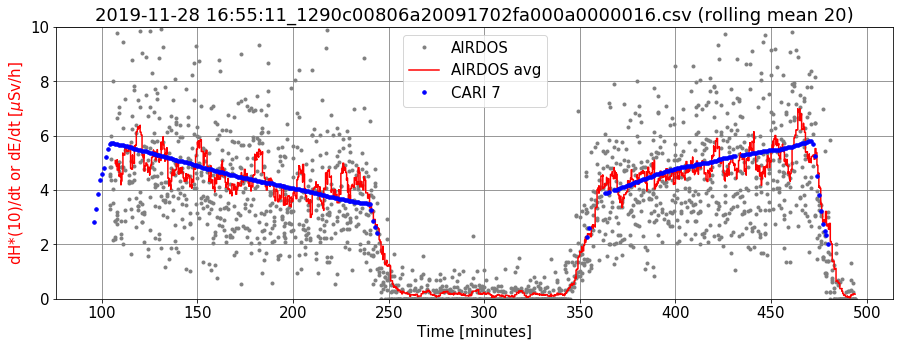

In [12]:
matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 8
LAST_CHANNEL=254
WINDOW = 20

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    plt.figure(figsize=(15,5))
    plt.tight_layout()
    xx = pd.read_csv(f)
    xx['date'] = pd.to_datetime(xx['date'])
    #xx.set_index('date', inplace = True)
    #xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']

    s = f.split('/')
    plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
        
    # Deposited energy
    e = pd.DataFrame()
    e['Ch']=range(0,256)
    e['ener'] = e.index * 0.038 + 0.105
    xx['ener'] = (np.asarray(xx.iloc[:,8:256]) * np.asarray(e.loc[3:250,'ener'])).sum(axis=1)    
    

    # size of the chip (20 mm · 10 mm), 
    # the thickness of the depletion layer (0.3 mm), 
    # and the density of silicon (2.33 g cm^3)
    # 0.1398e-3 kg
    xx['dsi'] = ((1e6 * (1.602e-19 * xx['ener'] * 1e6)/0.1398e-3)/10.4) * 3600 * 2.71 # in uGy/h

    xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

    xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()
    xx['dsimean'] = xx['dsi'].rolling(WINDOW).mean()

    #plt.plot(xx['minute'], xx['flux'], c='gray', linestyle='', marker='.')
    plt.plot(xx['minute'], xx['dsi'], c='gray', linestyle='', marker='.', label='AIRDOS')
    plt.plot(xx['minute'],xx['dsimean'],c='red', drawstyle='steps-mid', label='AIRDOS avg')
    #plt.plot(xx.iloc[:,'minute'],xx['fluxmean']c='red')
    #plt.plot(xx.loc[:,'minute'],xx.iloc[:,NOISE_LEVEL],c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

    # CARI 7
    f = './data/ble.DAT' #  File to Open
    df = pd.read_csv(f, engine='python', header=None, delim_whitespace=True, skiprows=2, skipfooter=3 )
    plt.plot(df.loc[(df[3]>95)&(df[4]>2),3],df.loc[(df[3]>95)&(df[4]>2),4], c='blue', markersize=7, marker='.', linestyle='none', label='CARI 7')
    
    plt.ylim([0,10])
    #plt.yscale('log')

    plt.xlabel('Time [minutes]')
    plt.ylabel(r'dH*(10)/dt or dE/dt [$\mu$Sv/h]', color='red')
    plt.legend(loc=2)
    
    '''
    ax = plt.twinx()

    plt.ylim([0,14000])
    plt.plot(xx['minute'], xx['altitude'], c='b', label='alt', marker='.', linewidth='2', linestyle='none', drawstyle='steps-mid')
    plt.ylabel('altitude a.s.l. [m]', color='blue')
    '''
    plt.grid(b=True, which='major', color='grey', linestyle='-')
    plt.grid(b=True, which='minor', color='grey', linestyle='-')
    plt.legend()


# Plot dose from multiple devices 

In [13]:
for f in glob.iglob("./output/*.csv"): # delete all output files 
    print ('Deleting', f)
    os.remove(f)

for fto in ['./data/malaga/16/DATALOG.TXT','./data/malaga/21/DATALOG.TXT','./data/malaga/98/DATALOG.TXT','./data/malaga/F0/DATALOG.TXT']:

    print (fto)

    l=[]
    #l.extend(range(0,261))
    l.extend(range(0,258))
    df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
    #df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

    #
    ''' DEBUG
    df = df.reset_index(drop=True)
    df.drop(df[df.index > 100].index, inplace=True)
    '''#'''

    df.drop(df[df[0]=='$STROKE'].index, inplace=True)
    df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
    #df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
    df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
    df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
    df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
    df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
    #df.drop(df[df[0]=='$CANDY'].index, inplace=True)

    sn = df.loc[df[0]=='$AIRDOS'][3]
    print (sn[0])

    run = 0

    runs = []
    LatDD = np.nan
    LatD = np.nan
    LatM = np.nan
    LonDD = np.nan
    LonD = np.nan
    LonM = np.nan
    LatHem = ''
    LonHem = ''

    for i,r in df.iterrows():
        if (r[0] == '$AIRDOS'):
            run = run + 1
            date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
            time = 0
            timedelta = 0
            altitude = np.nan
            Lat = np.nan
            Lon = np.nan
            speed = np.nan
            flag = 0
            flagrun = 0
            print (run, end='')

        if (r[0] == '$GPRMC'):
            date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
            timedelta = time
            speed = r[7]
            LatHem = r.astype(str)[4]
            LonHem = r.astype(str)[6]
            if (LatHem=='S'):     # Conferr DDMM.MM to DD.DD
                LatS = -1
            else:
                LatS = 1
            if (LonHem=='W'):
                LonS = -1
            else:
                LonS = 1
            Lat = float(r[3])
            LatD = np.trunc(Lat/100)
            LatM = ((Lat/100) - LatD) * 100
            LatDD = LatD + LatM/60.0
            LatDD = LatDD * LatS  
            Lon = float(r[5])
            LonD = np.trunc(Lon/100)
            LonM = ((Lon/100) - LonD) * 100
            LonDD = LonD + LonM/60.0
            LonDD = LonDD * LonS         
            flag = 1

        if (r[0] == '$GPGGA'):
            altitude = r[9]

        df.at[i,'date'] = date
        df.at[i,'altitude'] = altitude
        df.at[i,'speed'] = speed

        if (r[0] == '$CANDY'):
            time = pd.to_numeric(r[2])  # read seconds from power on
            if (flag == 1):
                timedelta = time
                if (flagrun == 0):
                    runs.append([run,date,timedelta])
                    flagrun = 1
                flag = 0
            date_line = date + pd.to_timedelta(time - timedelta, unit='s')
            df.at[i,'date'] = date_line
            df.at[i,'run'] = run
            df.at[i,'lat'] = LatDD
            df.at[i,'lon'] = LonDD
            df.at[i,'latD'] = LatD
            df.at[i,'lonD'] = LonD
            df.at[i,'latM'] = LatM
            df.at[i,'lonM'] = LonM
            df.at[i,'latHem'] = LatHem
            df.at[i,'lonHem'] = LonHem


#    FROM = pd.to_datetime('2019-11-27 00:00:00')
#    TO = pd.to_datetime('2019-11-29 01:10:00')
    FROM = pd.to_datetime('2019-11-26 18:55:00')
    TO = pd.to_datetime('2019-11-29 01:00:00')

    dfo = df.copy()
    dfo = dfo.loc[(dfo['date']>FROM)&(dfo['date']<TO)]

    #01/2002, FL-27
    #DEG MIN N/S DEG MIN E/W FEET TIME(MIN)
    dfdeg = df[['latD','latM','latHem','lonD','lonM','lonHem','altitude','run','date']].copy()
    dfdeg['altitude'] *= 3.28084
    dfdeg['minute'] = 0
    dfo['minute'] = 0
    dfdeg = dfdeg.loc[(dfdeg['date']>FROM)&(dfdeg['date']<TO)]
    #dfdeg.reset_index(inplace=True)

    dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
    dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
    dfo.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)
    dfdeg.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
    dfdeg.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
    dfdeg.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)

    print ()



    dfo.set_index('date', inplace = True)

    #01/2002, FL-27
    #DEG MIN N/S DEG MIN E/W FEET TIME(MIN)

    for x in runs: 
        filename = './output/' + str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0])

        # Disimetric values
        dfo.loc[dfo['run'] == x[0],'minute'] = (pd.to_timedelta(dfo.loc[dfo['run'] == x[0]].index-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)
        dfo.loc[dfo['run'] == x[0]].to_csv(filename + '.csv')

        # zeroing minutes for CARI
        zerominutes = np.round((pd.to_timedelta(dfdeg.iloc[0,8]-(x[1] + pd.to_timedelta(-x[2], unit='s')))).total_seconds()/60,0)

        # Telemetry for CARI 7
        with open(filename + '.DEG', 'w') as f:
            f.write('01/2002, FL-27\r\n')
            f.write('DEG MIN N/S DEG MIN E/W FEET TIME(MIN)\r\n')
        with open('ble.DEG', 'w') as f:
            f.write('11/2019, FL-27\r\n')
            f.write('DEG MIN N/S DEG MIN E/W FEET TIME(MIN)\r\n')
        #dfdeg.loc[dfdeg['run'] == x[0],'minute'] = (pd.to_timedelta(-dfdeg.iloc[0,8]+dfdeg['date']-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)-119
        #dfdeg.loc[dfdeg['run'] == x[0],'minute'] = (pd.to_timedelta(dfdeg['date']-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)-zerominutes
        dfdeg.loc[dfdeg['run'] == x[0],['latD','latM', 'latHem', 'lonD', 'lonM', 'lonHem', 'altitude', 'minute']].dropna().drop_duplicates(subset='minute', keep='first').to_csv('ble.DEG', mode='a', index=False, header=False, line_terminator='\r\n')
               
    print('End')



Deleting ./output/2019-11-28 16:55:13_1290c00806a200912821a000a0000098.csv
Deleting ./output/2019-11-28 16:55:11_1290c00806a20091702fa000a0000016.csv
./data/malaga/16/DATALOG.TXT
1290c00806a20091702fa000a0000016
1
End
./data/malaga/21/DATALOG.TXT
1290c00806a200912457a000a0000021
1
End
./data/malaga/98/DATALOG.TXT
1290c00806a200912821a000a0000098
1
End
./data/malaga/F0/DATALOG.TXT
1290c00806a20090f457a000a00000f0
1
End


./output/2019-11-28 16:55:11_1290c00806a20091702fa000a0000016.csv
./output/2019-11-28 16:55:09_1290c00806a200912457a000a0000021.csv
./output/2019-11-28 16:55:18_1290c00806a20090f457a000a00000f0.csv


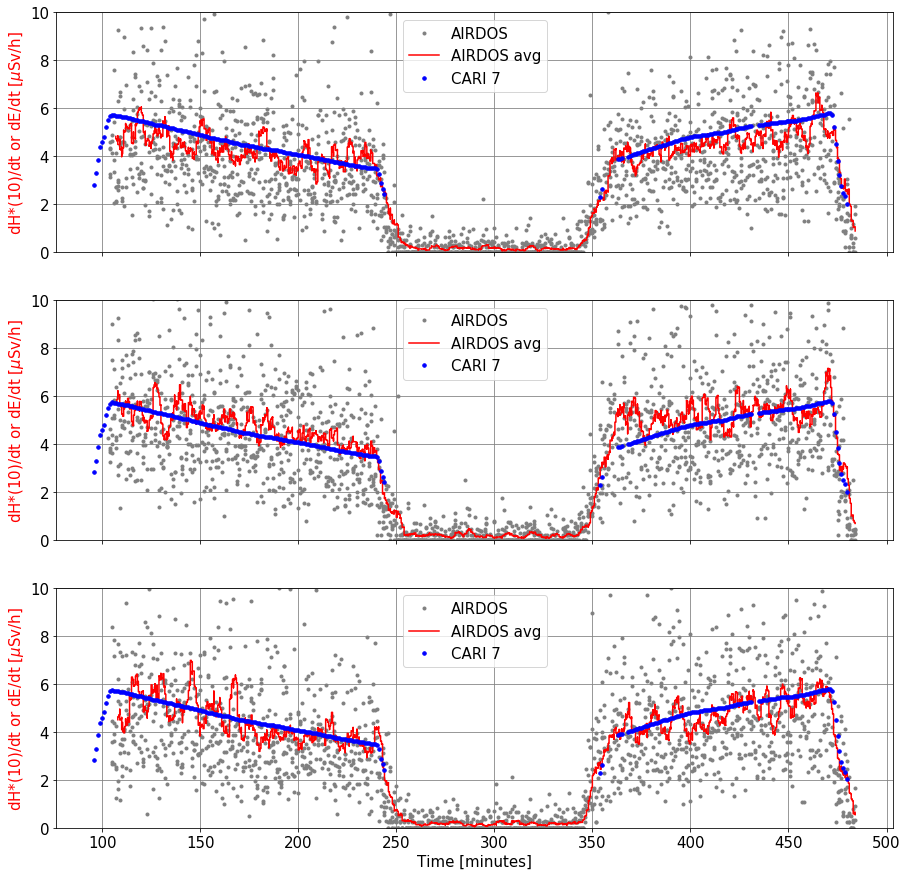

In [54]:
matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 8
LAST_CHANNEL=254
WINDOW = 20

plt.close('all')
#plt.tight_layout()

fig, ax = plt.subplots(3, sharex=True,figsize=(15,15))
graph = 0

#for ff in ['16','21','98','f0']: #glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
for ff in ['16','21','f0']: #glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    for f in glob.iglob("./output/*"+ff+".csv"):
        print(f)
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        #xx.set_index('date', inplace = True)
        #xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']

        s = f.split('/')
        #plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')

        # Deposited energy
        e = pd.DataFrame()
        e['Ch']=range(0,256)
        e['ener'] = e.index * 0.038 + 0.105
        xx['ener'] = (np.asarray(xx.iloc[:,8:256]) * np.asarray(e.loc[3:250,'ener'])).sum(axis=1)    
        if (ff == '21'):
            xx['ener'] = (np.asarray(xx.iloc[:,7:255]) * np.asarray(e.loc[3:250,'ener'])).sum(axis=1)    
        if (ff == '98'):
            xx['ener'] = (np.asarray(xx.iloc[:,9:256]) * np.asarray(e.loc[3:249,'ener'])).sum(axis=1)    

        # size of the chip (20 mm · 10 mm), 
        # the thickness of the depletion layer (0.3 mm), 
        # and the density of silicon (2.33 g cm^3)
        # 0.1398e-3 kg
        #xx['dsi'] = ((1e6 * (1.602e-19 * xx['ener'] * 1e6)/0.1398e-3)/10.4) * 3600 * 1.14 * 2.45 # in uGy/h
        xx['dsi'] = ((1e6 * (1.602e-19 * xx['ener'] * 1e6)/0.1398e-3)/10.4) * 3600 * 1.05 * 2.45 # in uGy/h

        xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

        xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()
        xx['dsimean'] = xx['dsi'].rolling(WINDOW).mean()

        ax[graph].plot(xx['minute'], xx['dsi'], c='gray', linestyle='', marker='.', label='AIRDOS')
        ax[graph].plot(xx['minute'],xx['dsimean'],c='red', drawstyle='steps-mid', label='AIRDOS avg')

        # CARI 7
        f = './data/ble.DAT' #  File to Open
        df = pd.read_csv(f, engine='python', header=None, delim_whitespace=True, skiprows=2, skipfooter=3 )
        ax[graph].plot(df.loc[(df[3]>95)&(df[4]>2),3],df.loc[(df[3]>95)&(df[4]>2),4], c='blue', markersize=7, marker='.', linestyle='none', label='CARI 7')

        ax[graph].set_ylim([0,10])
        #plt.yscale('log')

        plt.xlabel('Time [minutes]')
        ax[graph].set_ylabel(r'dH*(10)/dt or dE/dt [$\mu$Sv/h]', color='red')
        ax[graph].legend(loc=2)

        ax[graph].grid(b=True, which='major', color='grey', linestyle='-')
        ax[graph].grid(b=True, which='minor', color='grey', linestyle='-')
        ax[graph].legend()

        graph += 1


PRG-AGP
AIRDOS dH*(10)/dt [uSv/h]	 4.5713334823096385	sigma 0.803591827679402
CARY dE/dt [uSv/h]	 4.572275652173913	sigma 0.5814392653018736


<ipython-input-93-15aab676058b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  si['date'] = datetime(2000,1,1) + pd.TimedeltaIndex(si['minute'], unit='m')


"\nsi = xx.loc[(xx['minute']>370)&(xx['minute']<460)]\ncary = df.copy()\ncary[3] = cary[3] - 3\ncary = cary.loc[(cary[3]>370)&(cary[3]<460)]\n\nprint('PRG-AGP')\nprint('AIRDOS dH*(10)/dt [uSv/h]\t', si['dsi'].mean(),end='')\nprint('\tsigma', si['dsi'].std())\nprint('CARY dE/dt [uSv/h]\t', cary[4].mean(),end='')\nprint('\tsigma', cary[4].std())\n\nplt.plot(si['minute'],si['dsi'])\nplt.plot(cary[3],cary[4])\n"

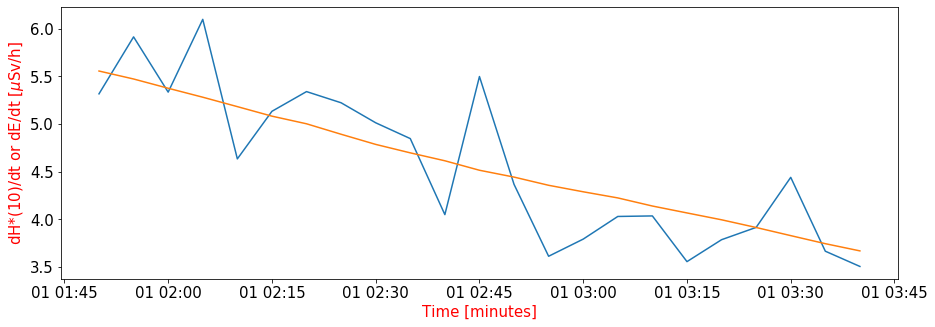

In [93]:
plt.figure(figsize=(15,5))
plt.ylabel(r'dH*(10)/dt or dE/dt [$\mu$Sv/h]', color='red')
plt.xlabel('Time [minutes]', color='red')

#plt.plot(xx['minute'],xx.iloc[:]['dsi'])
#plt.plot(df.iloc[120:225,4])
#plt.plot(df.iloc[370:480,4])
#plt.plot(df[3],df[4])
#plt.plot(df[3]-3,df[4])

si = xx.loc[(xx['minute']>110)&(xx['minute']<225)]

si['date'] = datetime(2000,1,1) + pd.TimedeltaIndex(si['minute'], unit='m')
si.set_index('date', inplace = True)

cary = df.copy()
cary[3] = cary[3] - 3
cary = cary.loc[(cary[3]>110)&(cary[3]<225)]

cary[3] = datetime(2000,1,1) + pd.TimedeltaIndex(cary[3], unit='m')
cary.set_index(3, inplace = True)

si = si.resample('5T').mean()
cary = cary.resample('5T').mean()

print('PRG-AGP')
print('AIRDOS dH*(10)/dt [uSv/h]\t', si['dsi'].mean(),end='')
print('\tsigma', si['dsi'].std())
print('CARY dE/dt [uSv/h]\t', cary[4].mean(),end='')
print('\tsigma', cary[4].std())

#plt.plot(si['minute'],si['dsi'])
#plt.plot(cary[3],cary[4])
plt.plot(si['dsi'])
plt.plot(cary[4])
'''
si = xx.loc[(xx['minute']>370)&(xx['minute']<460)]
cary = df.copy()
cary[3] = cary[3] - 3
cary = cary.loc[(cary[3]>370)&(cary[3]<460)]

print('PRG-AGP')
print('AIRDOS dH*(10)/dt [uSv/h]\t', si['dsi'].mean(),end='')
print('\tsigma', si['dsi'].std())
print('CARY dE/dt [uSv/h]\t', cary[4].mean(),end='')
print('\tsigma', cary[4].std())

plt.plot(si['minute'],si['dsi'])
plt.plot(cary[3],cary[4])
'''

## Plot Flux

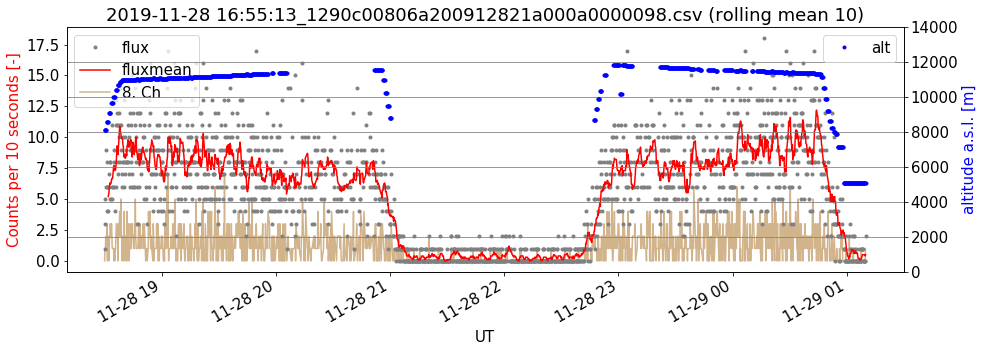

In [816]:
matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 8
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        #xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']

        
        xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

        xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

        xx['flux'].plot(c='gray', linestyle='', marker='.')
        xx['fluxmean'].plot(c='red')
        xx.iloc[:,NOISE_LEVEL].plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

        s = f.split('/')
        plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
        #plt.ylim([0,20])
        plt.xlabel('UT')
        plt.ylabel('Counts per 10 seconds [-]', color='red')
        plt.legend(loc=2)

        ax = plt.twinx()
                
        plt.ylim([0,14000])
        xx['altitude'].plot(c='b', label='alt', marker='.', linewidth='2', linestyle='none', drawstyle='steps-mid')
        plt.ylabel('altitude a.s.l. [m]', color='blue')

        plt.grid(b=True, which='major', color='grey', linestyle='-')
        plt.grid(b=True, which='minor', color='grey', linestyle='-')
        plt.legend()
    except:
        pass



# CARI 7

In [717]:
f = './ble.DAT' #  File to Open
df = pd.read_csv(f, engine='python', header=None, delim_whitespace=True, skiprows=2, skipfooter=3 )


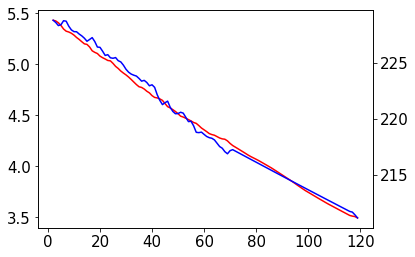

In [718]:
plt.plot(df[3],df[4], c='red')
plt.twinx()
plt.plot(df[3],df[2], c='blue')

## Plot Energy Spectra

0.03850279329608939 -0.040592178770949686


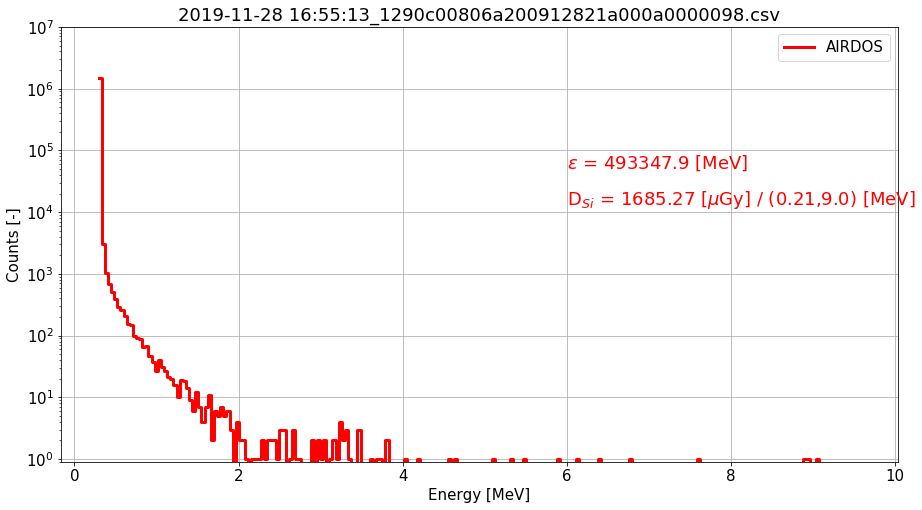

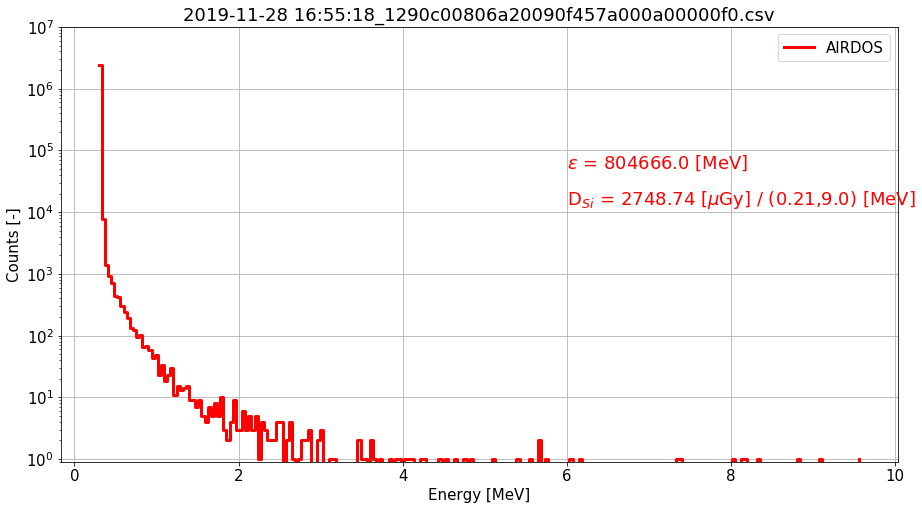

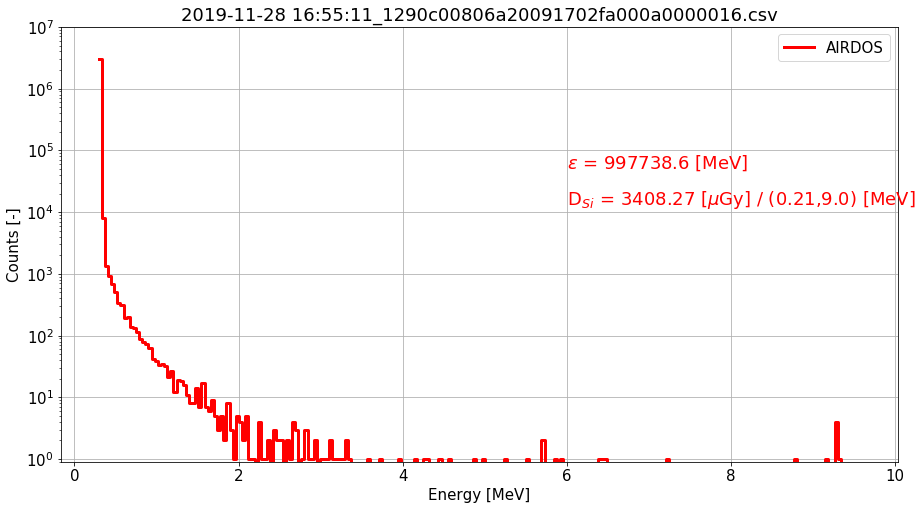

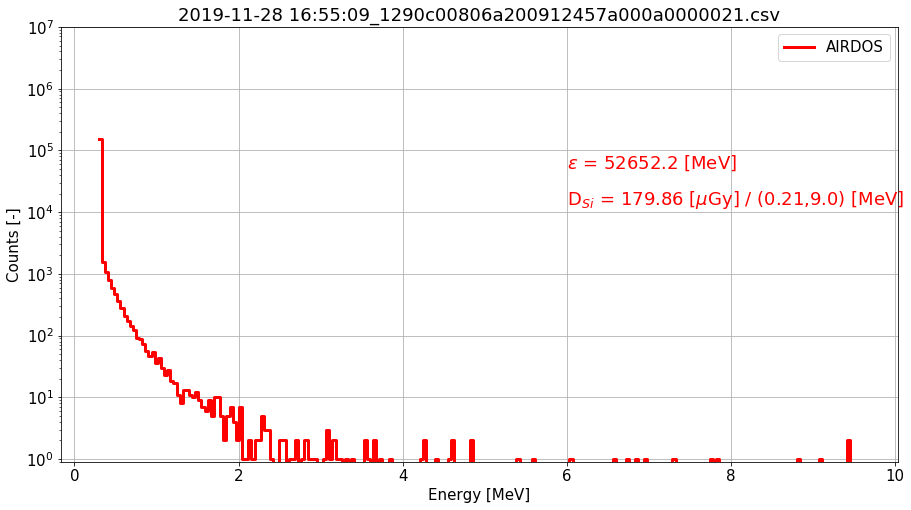

In [23]:
matplotlib.rcParams.update({'font.size': 15})

FROM_ENERGY = 0.21
TO_ENERGY = 9.0

l = np.array([[29+4, 1],[208+4,1]]) # Calibration
r = np.array([1.23, 8.122])
coef = np.linalg.solve(l,r)
print (coef[0], coef[1])

# force calibration coeficients
coef[0]=0.038
coef[1]=0.105
    
    
for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:        
        LOW_ENERGY = 5
        
        df = pd.read_csv(f)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace = True)
        
        # Uncomment this if you are interested in a specific time interval
        #xx = df.loc['2019-01-24 05:00:00':'2019-01-24 13:00:00']
        #from 2019-11-28 18:55 to 2019-11-28 20:55 was used for the flight PRG-AGP
        #from 2019-11-28 23:00 to 2019-11-29 00:30 was used for the flight AGP-PRG
        xx = df.loc['2019-11-28 18:55:00':'2019-11-28 20:55:00']
        #xx = df
        ener1 = xx.iloc[:,LOW_ENERGY:250].sum()
        e = pd.DataFrame()
        e['1'] = ener1
        e['index'] = pd.to_numeric(ener1.index)
        e['x'] = (e['index']) * coef[0] + coef[1]
        e['deposit'] = e['1'] * e['x']
        depener = e.loc[(e['x']>=FROM_ENERGY)&(e['x']<=TO_ENERGY),'deposit'].sum() # MeV

        dose = (1e6*(1.602e-19 * depener*1e6)/0.1398e-3) * 1.1

        # size of the chip (20 mm · 10 mm), 
        # the thickness of the depletion layer (0.3 mm), 
        # and the density of silicon (2.33 g cm^3)
        # 0.1398e-3 kg
        #dose = ((1e6 * (1.602e-19 * depener * 1e6)/0.1398e-3)/10.4) * 3600 * 2.71 # in uGy/h
        
        
        if (depener > 0):
            plt.figure(figsize=(15,8))
            plt.tight_layout()
            s = f.split('/')
            plt.title(s[len(s)-1])
            plt.yscale('log')
            plt.ylim([0.9,1e7])

            plt.plot(e['x'],e['1'], c='r', lw=3, drawstyle='steps-post', label='AIRDOS')

            plt.text(6, 50000, r'$\epsilon$ = ' + str(round(depener*1.1,1)) + ' [MeV]', fontsize=18, color='r')
            plt.text(6, 13000, r'D$_S$$_i$ = ' + str(round(dose*1.1*2.71,2)) + r' [$\mu$Gy] / (' + str(FROM_ENERGY) + ',' + str(TO_ENERGY) + ') [MeV]', fontsize=18, color='r')

            plt.legend()
            plt.xlabel('Energy [MeV]')
            plt.ylabel('Counts [-]')
            plt.grid()
    except:
        pass


In [810]:
print (FROM, TO)
print (xx.shape)
a = (TO - FROM)/np.timedelta64(1,'s')
print (a)
b = xx.shape[0]*10.4
print (b)
a/b

2019-11-28 18:55:00 2019-11-28 20:55:00
(470, 270)
7200.0
4888.0


1.4729950900163666

In [770]:
xx.iloc[:,7]
xx

,0,1,2,3,4,5,6,7,8,9,...,lon,latD,lonD,latM,lonM,latHem,lonHem,minute,flux,fluxmean
date,,,,,,,,,,,,,,,,,,,,,


# Plot Map

<Figure size 1080x360 with 0 Axes>

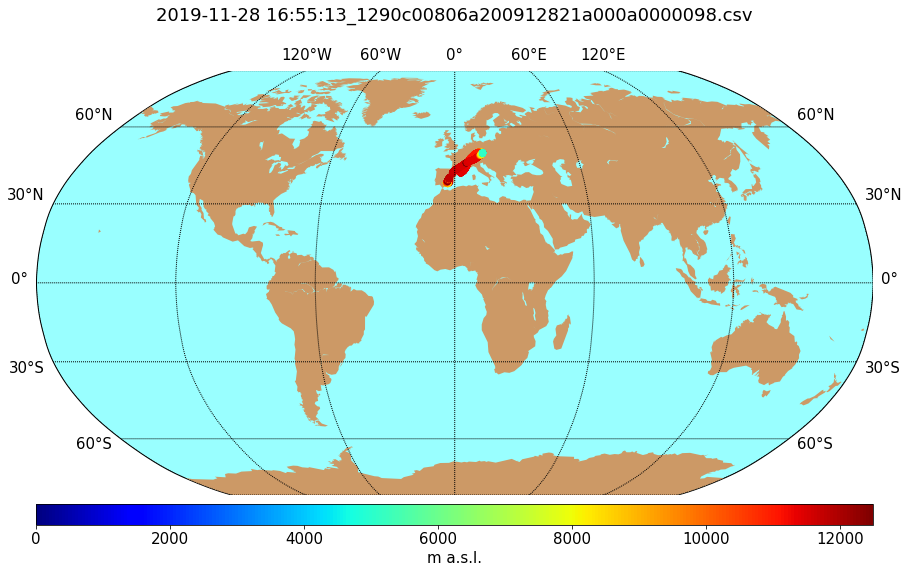

In [531]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

NOISE_LEVEL= 7
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        plt.figure(figsize=(15,15))
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        #m = Basemap(projection='cea',lon_0=0)
        m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        m.drawmapboundary(fill_color='#99ffff')
        m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,1,0])
        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    except:
        pass


<Figure size 1080x360 with 0 Axes>

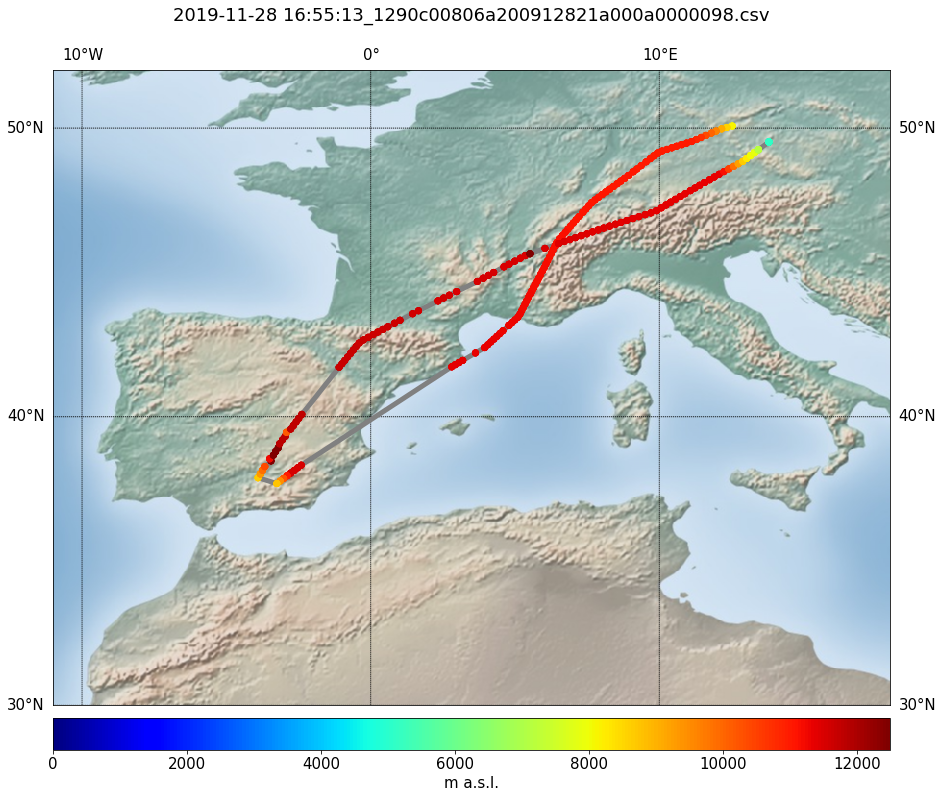

In [819]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

NOISE_LEVEL= 7
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        plt.figure(figsize=(15,15))
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        #m = Basemap(projection='cea',lon_0=0)
        #m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')
        m = Basemap(projection='cyl',lon_0=0, llcrnrlon=-11,llcrnrlat=30,urcrnrlon=18,urcrnrlat=52)

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        #m.drawmapboundary(fill_color='#99ffff')
        m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(-90.,99.,10.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(-180.,180.,10.),labels=[0,0,1,0])
        m.shadedrelief()
        
        m.plot(x,y, zorder=2, color='gray', lw=5)
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet', zorder=99)

        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    except:
        pass


# REFLECT

In [101]:
fto = './data/A001/DATALOG.TXT' #  File to Open

print (fto)

l=[]
l.extend(range(0,520))
#l.extend(range(0,258))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)



./data/A001/DATALOG.TXT


In [114]:
run = 0

runs = []
LatDD = np.nan
LonDD = np.nan

for i,r in df.iterrows():
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        if (r.astype(str)[4]=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (r.astype(str)[6]=='W'):
            LonS = -1
        else:
            LonS = 1
        Lat = float(r[3])
        LatDD = (Lat/100)
        LatDD = LatDD + (Lat - 100.0*LatDD)/60.0
        LatDD = LatDD * LatS  
        Lon = float(r[5])
        LonDD = (Lon/100)
        LonDD = LonDD + (Lon - 100.0*LonDD)/60.0
        LonDD = LonDD * LonS         
        flag = 1

    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$CANDY'):
        time = pd.to_numeric(r[1])*10  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        date_line = date + pd.to_timedelta(time - timedelta, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        
        
dfo = df.copy()
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)



dfo.set_index('date', inplace = True)



/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


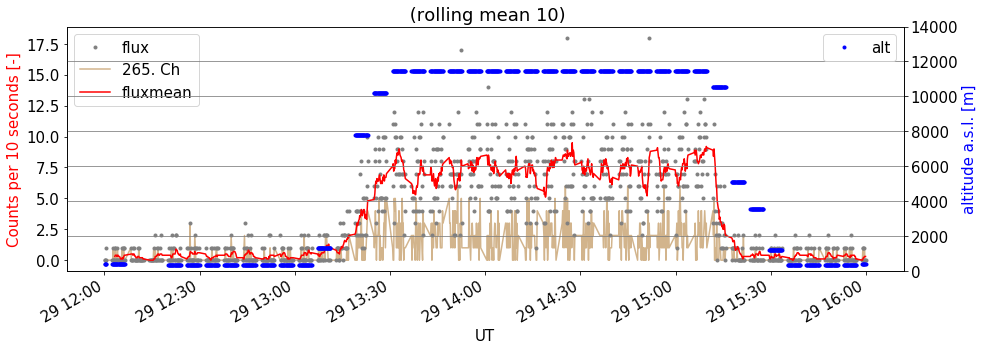

In [115]:
matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 265
LAST_CHANNEL=400
WINDOW = 10

#xx = dfo
xx = dfo.loc['2017-11-29 12:00:00':'2017-11-29 16:00:00']

plt.figure(figsize=(15,5))
plt.tight_layout()

xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx.iloc[:,NOISE_LEVEL].plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)
xx['fluxmean'].plot(c='red')

s = f.split('/')
plt.title(' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,20])
plt.xlabel('UT')
plt.ylabel('Counts per 10 seconds [-]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

plt.ylim([0,14000])
xx['altitude'].plot(c='b', label='alt', marker='.', linewidth='2', linestyle='none', drawstyle='steps-mid')
plt.ylabel('altitude a.s.l. [m]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



## Calculate Flux

/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. 

Text(0, 0.5, 'Flux [counts per 10 s]')

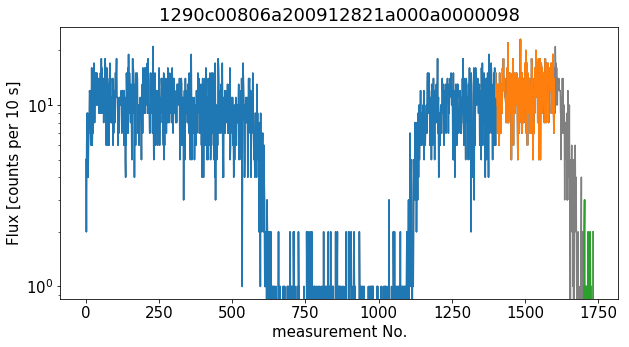

In [561]:
rc = df.loc[df['0']=='$CANDY']
rc.reset_index(drop=True, inplace=True)

rc = rc.apply(pd.to_numeric, errors='coerce')

rc['sum'] = rc.iloc[:,7:255].sum(axis=1)

plt.figure(figsize=(10,5))

rc.ix[0:,'sum'].plot(c='gray')
plt.yscale('log')

e1 = [0,1600]
e2 = [1400,1600]
e3 = [1700,1900]
e4 = [1,1]

rc.ix[e1[0]:e1[1],'sum'].plot()
rc.ix[e2[0]:e2[1],'sum'].plot()
rc.ix[e3[0]:e3[1],'sum'].plot()
rc.ix[e4[0]:e4[1],'sum'].plot()

plt.title(sn[0])
plt.xlabel('measurement No.')
plt.ylabel('Flux [counts per 10 s]')
#plt.ylim([0,50])
#plt.xlim([900,1200])

#print e1[1]

In [557]:
df

,0,1,2,3,4,5,6,7,8,9,...,run,lat,lon,latD,lonD,latM,lonM,latHem,lonHem,minute
date,,,,,,,,,,,,,,,,,,,,,
2019-11-28 18:29:58,$CANDY,470,5685,26,19187,2775,5,0,0,1,...,1.0,50.071993,12.524191,50.0,12.0,4.31955,31.45147,N,E,94
2019-11-28 18:30:10,$CANDY,471,5697,12,18843,3119,2,2,1,0,...,1.0,50.071993,12.524191,50.0,12.0,4.31955,31.45147,N,E,94
2019-11-28 18:30:22,$CANDY,472,5709,21,18838,3088,2,1,1,0,...,1.0,50.071993,12.524191,50.0,12.0,4.31955,31.45147,N,E,95
2019-11-28 18:30:34,$CANDY,473,5721,17,18796,3122,5,0,2,0,...,1.0,50.071993,12.524191,50.0,12.0,4.31955,31.45147,N,E,95
2019-11-28 18:30:46,$CANDY,474,5733,15,18821,3131,4,0,1,3,...,1.0,50.071993,12.524191,50.0,12.0,4.31955,31.45147,N,E,95
2019-11-28 18:31:03,$CANDY,475,5750,16,18734,3205,9,0,2,1,...,1.0,50.023301,12.340839,50.0,12.0,1.39808,20.45034,N,E,95
2019-11-28 18:31:15,$CANDY,476,5762,16,18639,3263,7,1,3,0,...,1.0,50.023301,12.340839,50.0,12.0,1.39808,20.45034,N,E,96
2019-11-28 18:31:27,$CANDY,477,5774,21,18762,3150,4,3,0,2,...,1.0,50.023301,12.340839,50.0,12.0,1.39808,20.45034,N,E,96
2019-11-28 18:31:39,$CANDY,478,5786,15,18700,3210,6,0,2,0,...,1.0,50.023301,12.340839,50.0,12.0,1.39808,20.45034,N,E,96


## Energy spectrum

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: Deprecatio

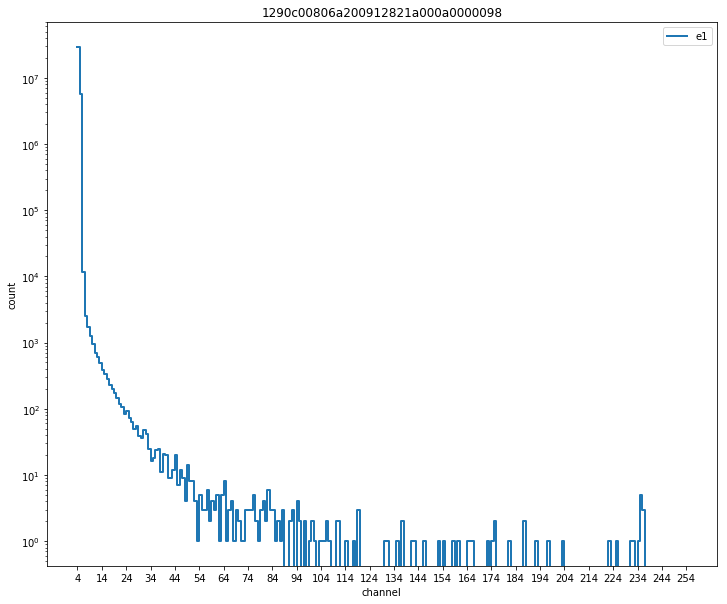

In [567]:
#%matplotlib notebook
%matplotlib inline

#matplotlib.rcParams.update({'font.size': 20})

LOW_ENERGY = 4

ener1 = rc.ix[e1[0]:e1[1],LOW_ENERGY:255].sum()
ener2 = rc.ix[e2[0]:e2[1],LOW_ENERGY:255].sum()
ener3 = rc.ix[e3[0]:e3[1],LOW_ENERGY:255].sum()
ener4 = rc.ix[e4[0]:e4[1],LOW_ENERGY:255].sum()

plt.figure(figsize=(12,10))
plt.yscale('log')

#plt.plot(ener1, label='e',  drawstyle='steps-post')
plt.plot(ener1, label='e1', lw=2, drawstyle='steps-post')
#plt.plot(ener2, label='e2', lw=2, drawstyle='steps-post')
#plt.plot(ener3, label='e3', lw=2, drawstyle='steps-post')
#plt.plot(ener2, label='background', lw=2, drawstyle='steps-post')
#plt.plot(ener1-ener2, label='Ba-133 - background', lw=2, drawstyle='steps-post')
#plt.plot(ener3-ener2, label='Na-22 - background', lw=2, drawstyle='steps-post')

#plt.ylim([0,10000])
#plt.xlim([0,40])
plt.legend()
plt.title(sn[0])
#plt.title('AIRDOS T4 Alpha Spectrum')
plt.xlabel('channel')
plt.ylabel('count')
plt.xticks(range(0,255,10))
#plt.xticks(rotation=90)
#plt.grid()

#ener1.to_csv('e1.csv')
#ener2.to_csv('e2.csv')
#ener3.to_csv('e3.csv')

None

# Spectrum Interactive

In [ ]:
%matplotlib qt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import matplotlib.pyplot as plt

fto = './data/DATALOG.TXT' #  File to Open
#fto = './data/DATALOG_FRA_TRN.TXT' #  File to Open
l=[]
l.extend(range(0,520))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)


matplotlib.rcParams.update({'font.size': 20})

rc = df.loc[df[0]=='$CANDY']
rc.reset_index(drop=True, inplace=True)

rc = rc.apply(pd.to_numeric, errors='coerce')

#rc.to_csv('ble.txt')

#rc['sum'] = rc[range(260,516)].sum(axis=1)
rc['sum'] = rc[range(260,516)].sum(axis=1)
#rc['sum']

plt.figure(figsize=(20,5))

#rc['sum'].plot()
rc.ix[:,'sum'].plot()

plt.title('AIRDOS')
plt.xlabel('measurement No.')
plt.ylabel('Flux [counts per 11 s]')


points=plt.ginput(2)

plt.figure(figsize=(20,5))
rc.ix[points[0][0]:points[1][0],'sum'].plot()
points=plt.ginput(2)

#ener = rc.ix[points[0][0]:points[1][0],260:516].sum()
ener = rc.ix[points[0][0]:points[1][0],260:514].sum()

plt.figure(figsize=(20,5))

plt.plot(ener)



/usr/lib/python2.7/dist-packages/matplotlib/backend_bases.py:2437: MatplotlibDeprecationWarning:

Using default event loop until function specific to this GUI is implemented



## Plot histogram

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


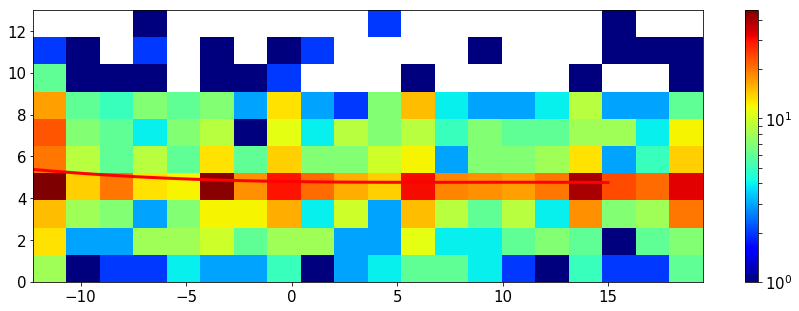

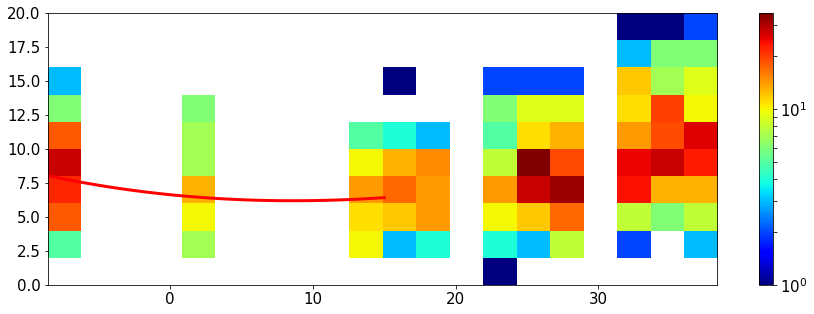

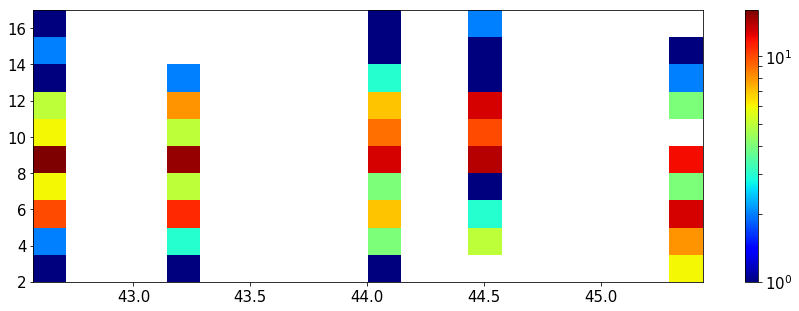

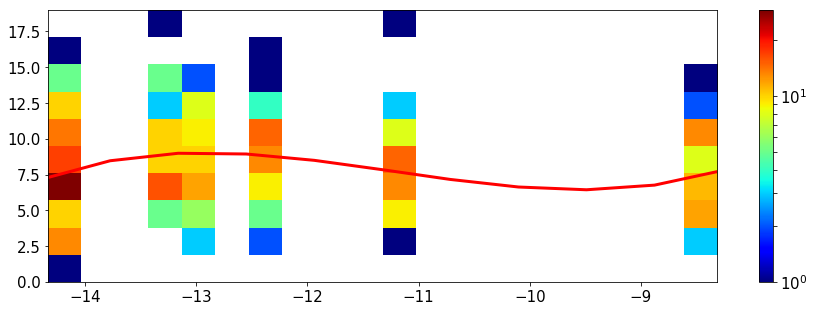

In [91]:
import scipy as sp

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    plt.figure(figsize=(15,5))
    plt.tight_layout()
    df = pd.read_csv(f)
    df.dropna(inplace=True)
    df['lat'] = pd.to_numeric(df['lat'])
    df['lon'] = pd.to_numeric(df['lon'])
    df['altitude'] = pd.to_numeric(df['altitude'])
    df6 = df.loc[df['altitude'] > 12100]

    df6['flux'] = df6.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
    plt.hist2d(df6['lat'], df6['flux'], bins=(20,10), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
    plt.colorbar()
    pf_coef = np.polyfit(df6['lat'],df6['flux'],3)     # polynomial aproximation
    p = np.poly1d(pf_coef)
    plt.plot(sp.linspace(-15,15), p(sp.linspace(-15,15)), 'r-', c='red', lw=3)


In [13]:
dfo.to_csv('./output/ble.csv')